## DQN sobre ambientes de Classic Control

https://gymnasium.farama.org/environments/classic_control/

### Imports

In [2]:
import torch
import numpy as np
import random
import numpy as np
import gymnasium

### Seteamos los devices

In [3]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Running on {DEVICE}")
print("Cuda Available:", torch.cuda.is_available())

Running on cuda:0
Cuda Available: True


### Seteo de seeds
Siempre es buena práctica hacer el seteo de seeds para la reproducibilidad de los experimentos

In [4]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

### Creamos el ambiente y probamos algunas de sus funciones.

En este caso elegimos el CartPole pero pueden cambiarlo en la variable *ENV_NAME*.
El ambiente CartPole tiene la ventaja de que las recompensas son positivas y es mas fácil propagar estas hacia los estados iniciales. Mountain Car tiene como recompensa -1 por cada paso que damos y esta limitado a 200 pasos.

In [5]:
ENVS = ["MountainCar-v0", "CartPole-v1", "Acrobot-v1"]
ENV_NAME = ENVS[1]

env = gymnasium.make(ENV_NAME, render_mode="rgb_array")

print("Actions #",env.action_space)
print(env.observation_space.shape)
env.reset()
next_state, reward, terminated, truncated, info = env.step(action=0)

print(f"{next_state.shape},\n {reward},\n {terminated},\n {info}")

Actions # Discrete(2)
(4,)
(4,),
 1.0,
 False,
 {}


### Seteamos los hyperparámetros

In [6]:
def process_state(obs, device):
    return torch.tensor(obs, device=device).unsqueeze(0)

#Hiperparámetros de entrenamiento del agente DQN
TOTAL_STEPS = 1000000
EPISODES = 1000
STEPS = 300

EPSILON_INI = .9
EPSILON_MIN = 0.05
EPSILON_DECAY = 50000
EPISODE_BLOCK = 100
EPSILON_TIME = 100000

BATCH_SIZE = 128
BUFFER_SIZE = 10000

GAMMA = 0.99
LEARNING_RATE = 0.0001
ACTOR_LR = 0.00001

### Creamos el ambiente que vamos a estar usando para el entrenamiento

In [7]:
env = gymnasium.make(ENV_NAME)
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

print(f"Input dim: {input_dim}, Output dim: {output_dim}")

Input dim: 4, Output dim: 2


In [13]:
import utils
env = utils.make_env(ENV_NAME, render_mode='rgb_array')

In [14]:
from actor_critic_models import ActorModel, CriticModel
from actor_critic_agent import ActorCriticAgent

actor = ActorModel(input_dim, output_dim).to(DEVICE)
critic = CriticModel(input_dim).to(DEVICE)

agent = ActorCriticAgent(env, actor, process_state, BUFFER_SIZE, BATCH_SIZE, LEARNING_RATE,
                          GAMMA, actor_lr=ACTOR_LR, epsilon_i= EPSILON_INI, epsilon_f=EPSILON_MIN,
                            epsilon_decay = EPSILON_DECAY, episode_block = EPISODE_BLOCK,
                              device=DEVICE, critic_model=critic)

In [ ]:
# from dqn_model import DQN_Model
# from dqn_agent import DQNAgent
# net = DQN_Model(input_dim, output_dim).to(DEVICE)

# agent = DQNAgent(env, net, process_state, BUFFER_SIZE, BATCH_SIZE, 
#                 LEARNING_RATE, GAMMA, epsilon_i= EPSILON_INI, 
#                 epsilon_f=EPSILON_MIN, epsilon_anneal_time=EPSILON_TIME,
#                 epsilon_decay = EPSILON_DECAY, episode_block = EPISODE_BLOCK, device=DEVICE, second_model_update=300)

In [ ]:
# from dqn_model import DQN_Model
# from double_dqn_agent import DoubleDQNAgent
# net = DQN_Model(input_dim, output_dim).to(DEVICE)
# net2 = DQN_Model(input_dim, output_dim).to(DEVICE)

# agent = DoubleDQNAgent(env, net, net2, process_state, BUFFER_SIZE, BATCH_SIZE, 
#                 LEARNING_RATE, GAMMA, epsilon_i= EPSILON_INI, epsilon_f=EPSILON_MIN, 
#                 epsilon_decay = EPSILON_DECAY, episode_block = EPISODE_BLOCK, device=DEVICE)

In [16]:
rewards = agent.train(EPISODES, TOTAL_STEPS, use_wandb=False)

  0%|          | 0/1000 [00:00<?, ?episode/s]


ValueError: axes don't match array

### Graficamos las recompensas obtenidas durante el entrenamiento 

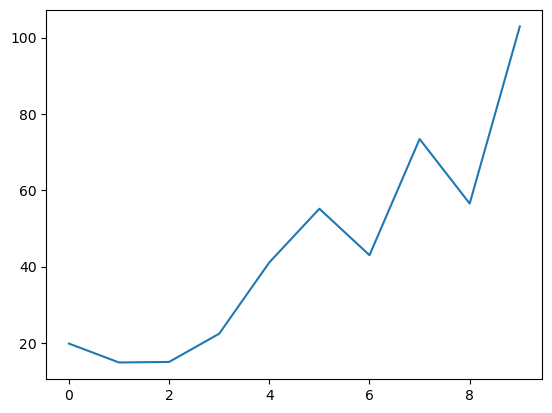

In [ ]:
import matplotlib.pyplot as plt

average_range = EPISODE_BLOCK
episode_ticks = int(len(rewards) / average_range)

avg_rewards = np.array(rewards).reshape((episode_ticks, average_range))
avg_rewards = np.mean(avg_rewards, axis=1)

plt.plot(range(len(avg_rewards)), avg_rewards)

### Creamos un video para ver la performance del agente

In [ ]:
import glob
from gymnasium.wrappers.record_video import RecordVideo
from IPython.display import HTML
from IPython import display as ipythondisplay
import io
import base64

def show_video():
  """
  Utility function to enable video recording of gym environment and displaying it
  To enable video, just do "env = wrap_env(env)""
  """
  mp4list = glob.glob('./video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  """
  Wrapper del ambiente donde definimos un Monitor que guarda la visualizacion como un archivo de video.
  """

  #env = Monitor(env, './video', force=True)
  env = RecordVideo(env,video_folder='./videos', name_prefix='video', episode_trigger=lambda x: x % 2 == 1)
  return env

In [ ]:
env = wrap_env(gymnasium.make(ENV_NAME, render_mode="rgb_array"))
observation,_ = env.reset()

while True:
    env.render()

    action = agent.select_action(process_state(observation, DEVICE), train=False)
    observation, reward, done, truncated, _ = env.step(action.item())

    if done:
      break

# Cerramos la conexion con el Monitor de ambiente y mostramos el video.
env.close()
show_video()

del env

Moviepy - Building video c:\Users\juan1\Ort\Agentes Inteligentes\reinforcement-learning\Atari\videos\video-episode-1.mp4.
Moviepy - Writing video c:\Users\juan1\Ort\Agentes Inteligentes\reinforcement-learning\Atari\videos\video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\juan1\Ort\Agentes Inteligentes\reinforcement-learning\Atari\videos\video-episode-1.mp4


In [ ]:
agent.env = gymnasium.make(ENV_NAME, render_mode="rgb_array")
agent.env.reset()
agent.make_video("video_test.mp4", True)

c:\Users\juan1\anaconda3\envs\TallerIA\lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\juan1\Ort\Agentes Inteligentes\reinforcement-learning\Atari\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video c:\Users\juan1\Ort\Agentes Inteligentes\reinforcement-learning\Atari\video\video_test.mp4-episode-0.mp4.
Moviepy - Writing video c:\Users\juan1\Ort\Agentes Inteligentes\reinforcement-learning\Atari\video\video_test.mp4-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\juan1\Ort\Agentes Inteligentes\reinforcement-learning\Atari\video\video_test.mp4-episode-0.mp4
